In [ ]:
!git clone https://github.com/MorningStarTM/unsupervised-pre-training-vgg.git

In [4]:
%cd /kaggle/working/unsupervised-pre-training-vgg

/kaggle/working/unsupervised-pre-training-vgg


In [5]:
!ls

LICENSE  README.md  notebooks  tensorflow_src  torch_modules


In [6]:
from tensorflow_src import Autoencoder
import os
import cv2
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from __future__ import absolute_import, division, print_function, unicode_literals
from glob import glob
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from keras.models import Model
from tqdm import tqdm
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import time
from tensorflow_src.pipeline import load_data, PlotImg, tf_dataset, process_image
from tensorflow_src.evaluation import batch_prediction
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from IPython import display
import matplotlib.gridspec as gridspec
from tensorflow_src.evaluation import load_ae
from keras.callbacks import *

2024-07-21 12:05:39.577087: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-21 12:05:39.577158: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-21 12:05:39.579063: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [7]:
BATCH_SIZE = 64
EPOCHS = 10
H,W,C = 256,256,3
lr = 1e-5
latent_dim = 512

# AutoEncoder

In [8]:
model = Autoencoder((256,256,3))
ae = model.build_autoencoder()
ae.summary()

Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder (Functional)            │ (None, 8, 8, 256)      │     7,855,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder (Functional)            │ (None, 256, 256, 3)    │    10,214,547 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,069,795 (68.93 MB)

 Trainable params: 18,069,795 (68.93 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
ae.load_weights("/kaggle/input/autoencoder/ae_model_256.keras")

# Extracted Encoder

In [10]:
latent = "max_pooling2d_4"
vgg = Model(inputs=ae.input, outputs=ae.get_layer("encoder").output)
vgg.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 256, 256, 16)   │         1,744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 256, 256, 16)   │         9,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 256, 256, 16)   │         9,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 128, 128, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 128, 128, 32)   │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 128, 128, 32)   │        36,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 128, 128, 32)   │        36,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 64, 64, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 64, 64, 64)     │       147,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 64, 64, 64)     │       147,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 32, 32, 128)    │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 32, 32, 128)    │       589,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 32, 32, 128)    │       589,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 16, 16, 256)    │     1,179,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 16, 16, 256)    │     2,359,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 16, 16, 256)    │     2,359,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 8, 8, 256)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,855,248 (29.97 MB)

 Trainable params: 7,855,248 (29.97 MB)

 Non-trainable params: 0 (0.00 B)

# Model

In [11]:
x = vgg.output
flatten = tf.keras.layers.Flatten()(x)
dense = tf.keras.layers.Dense(128, activation='relu')(flatten)
dense = tf.keras.layers.Dense(64, activation='relu')(dense)

outputs = tf.keras.layers.Dense(3, activation='softmax')(dense)
model = tf.keras.Model(vgg.input, outputs)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 256, 256, 16)   │         1,744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 256, 256, 16)   │         9,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 256, 256, 16)   │         9,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 128, 128, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 128, 128, 32)   │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 128, 128, 32)   │        36,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 128, 128, 32)   │        36,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 64, 64, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 64, 64, 64)     │       147,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 64, 64, 64)     │       147,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 32, 32, 128)    │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 32, 32, 128)    │       589,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 32, 32, 128)    │       589,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 16, 16, 256)    │     1,179,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 16, 16, 256)    │     2,359,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 16, 16, 256)    │     2,359,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     2,097,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │           19

 Total params: 9,960,979 (38.00 MB)

 Trainable params: 9,960,979 (38.00 MB)

 Non-trainable params: 0 (0.00 B)

# Data

In [16]:
root_path = "/kaggle/input/multi-cancer/Multi Cancer/Brain Cancer"
train, valid, test = load_data(root_path)
print(f"Train:{len(train)} - Valid: {len(valid)} - Test:{len(test)}")

Train:9000 - Valid: 3000 - Test:3000


In [17]:
train_df = tf_dataset(train)
valid_df = tf_dataset(valid)
test_df = tf_dataset(test)

In [18]:
for i,j in test_df.take(1):
    print(i.numpy().shape)

(32, 256, 256, 3)


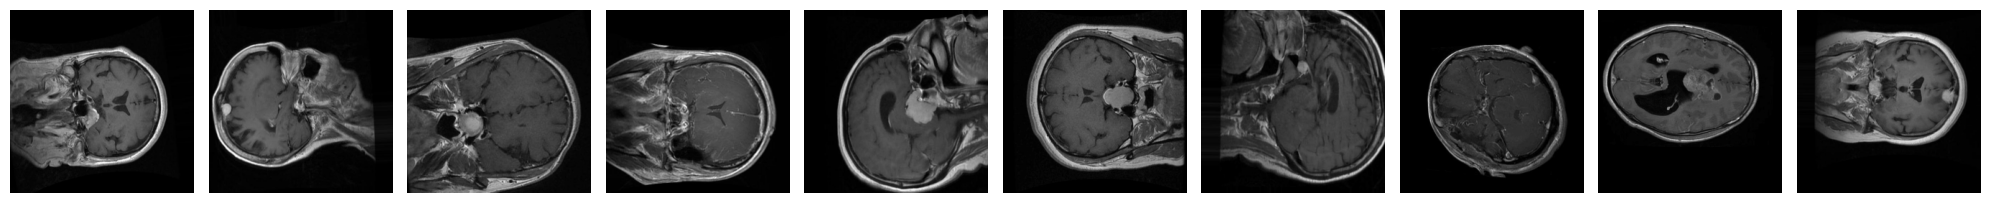

In [19]:
imgs, labels = next(iter(train_df))
PlotImg(imgs)

In [14]:
model_path = "/kaggle/working/fine_tuned_model.keras"
csv_path = "/kaggle/working/model.csv"
callbacks = [
    ModelCheckpoint(model_path, verbose=1, save_best_only=True),
    CSVLogger(csv_path),
    ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=6, min_lr=2e-9, verbose=1),
    EarlyStopping(monitor='val_loss', patience=9, verbose=1, restore_best_weights=True)
]

## Model compiling

In [12]:
model.compile(optimizer=tf.keras.optimizers.Adam(0.0003), loss='categorical_crossentropy', metrics=['accuracy'])

# Training

In [ ]:
r = model.fit(x=train_df, validation_data=valid_df, epochs=30, callbacks=callbacks)

In [15]:
model.load_weights(model_path)

/opt/conda/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 74 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [20]:
model.evaluate(test_df)

 3/94 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9965 - loss: 0.0110 

I0000 00:00:1721563630.165145     879 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


94/94 ━━━━━━━━━━━━━━━━━━━━ 23s 161ms/step - accuracy: 0.9944 - loss: 0.0163


[0.021262498572468758, 0.9933333396911621]

confusion matrix without normalization
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1033
           1       1.00      1.00      1.00       992
           2       1.00      0.98      0.99       975

    accuracy                           0.99      3000
   macro avg       0.99      0.99      0.99      3000
weighted avg       0.99      0.99      0.99      3000



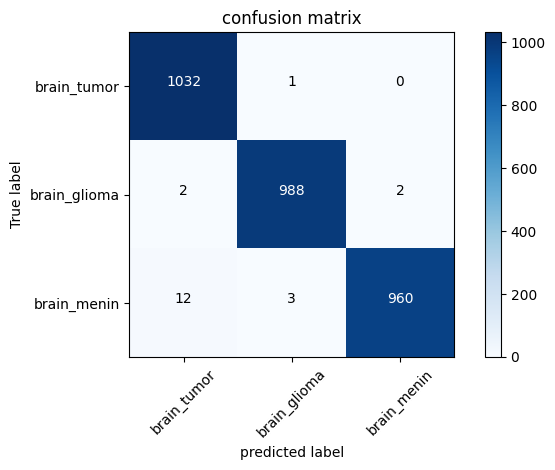

In [24]:
batch_prediction(model_path, test_df, test)